<a href="https://colab.research.google.com/github/damiangohrh123/ml_projects/blob/main/classification/CIFAR_10_CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 CNN Classifier (Deep Learning Project)

We'll be using PyTorch to classify 32×32 color images from the CIFAR-10 dataset into 10 categories.

In [ ]:
# !pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Step 1: Data Loading & Preprocessing
We'll use the CIFAR-10 dataset (50,000 training + 10,000 test images) provided by `torchvision.datasets`, which downloads the data automatically. Each image is 32×32 pixels, RGB, and represents one of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

We apply data transformations:

* Training set: random horizontal flips, random crops, and color
jitter for augmentation; convert to tensor; normalize to `[-1, 1]`

* Test set: convert to tensor and normalize to `[-1, 1]` (no augmentation)

In [ ]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transforms
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:42<00:00, 3.97MB/s]


## Step 2: Visualize Sample Training Images
Display a few augmented training images with their class labels.

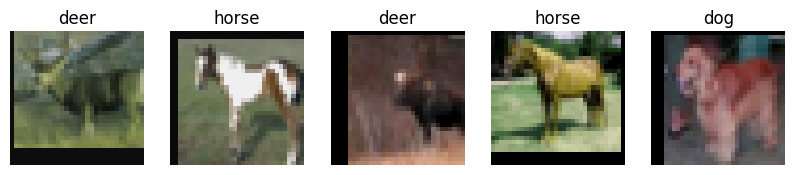

In [ ]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i].permute(1,2,0) * 0.5 + 0.5)  # unnormalize to [0,1]
    axes[i].set_title(classes[labels[i].item()])
    axes[i].axis('off')
plt.show()

## Step 3: Define CNN Architecture
We define a CNN model with the following structure:

1. Three convolutional blocks, each containing:
    * Convolutional layer → extracts feature maps from the RGB input
    * BatchNorm2d → stabilizes and speeds up training
    * ReLU activation → introduces non-linearity
    * MaxPooling → reduces spatial dimensions (downsampling)
    * Dropout → regularizes the model and reduces overfitting

2. Flatten layer → converts the final feature maps into a 1D vector

3. Fully connected layers with dropout → learn higher-level representations

4. Output layer → produces 10 outputs, one for each CIFAR-10 class

This architecture enables the network to learn increasingly complex features — from simple color/edge patterns in early layers to higher-level object representations in deeper layers.

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.network = nn.Sequential(
            # First convolutional block:
            # Input: 3 channels (RGB), Output: 32 feature maps
            # Kernel: 3x3, padding=1 (keeps spatial size 32x32)
            # BatchNorm for stability, ReLU activation, 2x2 Max Pooling (downsamples to 16x16)
            # 25% Dropout for regularization
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            # Second convolutional block:
            # Input: 32 channels, Output: 64 feature maps
            # Kernel: 3x3, padding=1 (keeps spatial size 16x16)
            # BatchNorm, ReLU, 2x2 Max Pooling (downsamples to 8x8)
            # 25% Dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            # Third convolutional block:
            # Input: 64 channels, Output: 128 feature maps
            # Kernel: 3x3, padding=1 (keeps spatial size 8x8)
            # BatchNorm, ReLU, 2x2 Max Pooling (downsamples to 4x4)
            # 25% Dropout
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            # Flatten the 3D feature maps (128x4x4) into a 1D vector of size 2048
            nn.Flatten(),

            # Fully connected (dense) layer:
            # Input: 2048 features, Output: 256 features
            # ReLU activation and 50% Dropout for regularization
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Output layer:
            # Input: 256 features, Output: 10 classes (CIFAR-10)
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.network(x)

model = CIFAR10CNN().to(device)
print(model)

CIFAR10CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
  

## Step 4: Define Loss Function and Optimizer
Use CrossEntropyLoss as the loss function and Adam as the optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 5: Training Loop
Train the CNN for multiple epochs. For each batch:
- Perform forward pass
- Compute loss
- Perform backward pass
- Update parameters
Track training loss and accuracy per epoch.

In [ ]:
epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy*100:.2f}%")

Epoch [1/10] - Loss: 1.7896 - Accuracy: 32.86%
Epoch [2/10] - Loss: 1.5804 - Accuracy: 41.21%
Epoch [3/10] - Loss: 1.4719 - Accuracy: 45.78%
Epoch [4/10] - Loss: 1.3966 - Accuracy: 49.37%
Epoch [5/10] - Loss: 1.3480 - Accuracy: 51.41%
Epoch [6/10] - Loss: 1.3003 - Accuracy: 53.28%
Epoch [7/10] - Loss: 1.2616 - Accuracy: 54.70%
Epoch [8/10] - Loss: 1.2229 - Accuracy: 56.20%
Epoch [9/10] - Loss: 1.1960 - Accuracy: 57.52%
Epoch [10/10] - Loss: 1.1751 - Accuracy: 58.21%


## Step 6: Plot Training Loss and Accuracy
Plot training loss and accuracy curves over epochs.

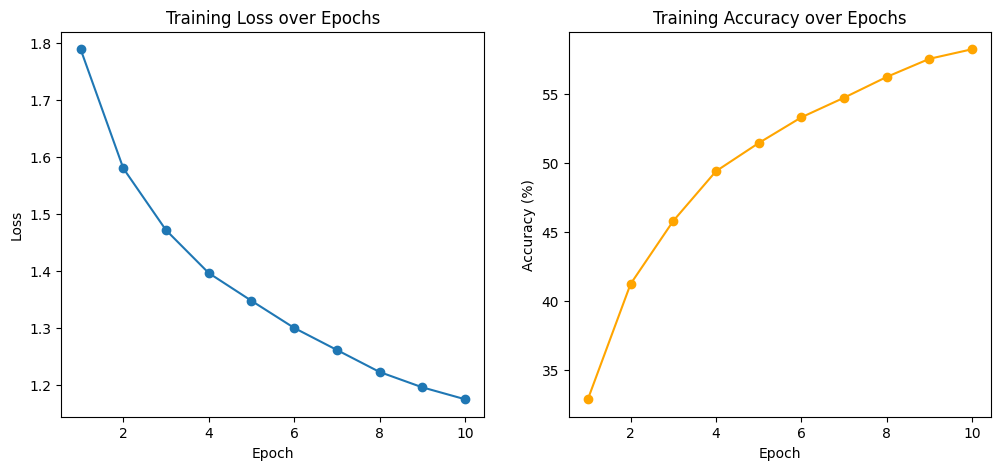

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), [a*100 for a in train_accuracies], marker='o', color='orange')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


## Step 7: Evaluate on Test Set
Compute test accuracy by performing a forward pass on all test batches without gradient tracking.


In [10]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 67.65%


## Step 8: Visualize Predictions
Display a small batch of test images along with their predicted and true labels.

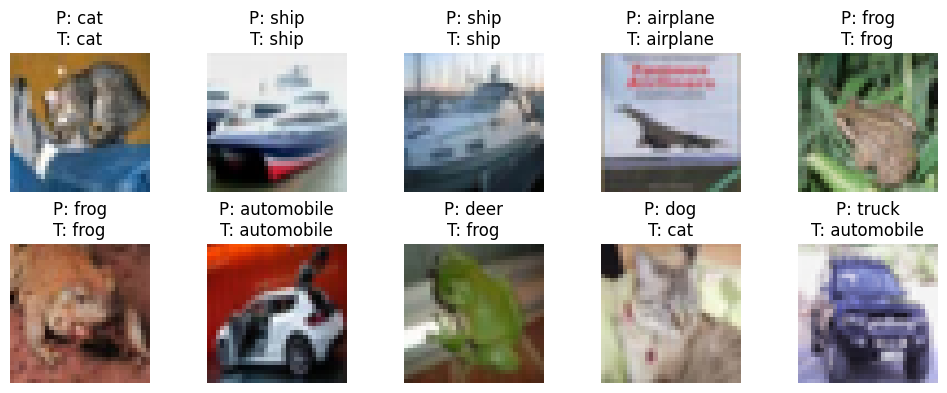

In [11]:
def show_predictions():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].cpu().permute(1,2,0) * 0.5 + 0.5)  # unnormalize
        ax.set_title(f"P: {classes[preds[i].item()]}\nT: {classes[labels[i].item()]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions()


## Conclusion
CNN trained with data augmentation, dropout, and batch normalization on CIFAR-10. Trained model achieves test accuracy typically around 70–75%. Next steps could include deeper networks, residual connections (ResNet), or advanced augmentations.